In [1]:
# Importing libraries for Naive Bayes implementation.
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn import model_selection

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals import joblib
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
# Reading data from previously created class variable or score and preprossed sample 100k data.
from sklearn.externals import joblib
target = joblib.load('target.joblib')
sample100K_data = joblib.load('sample100K_data_prepros.joblib')

# Bag of Words (BoW) implementation of Naive Bayes

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
X = sample100K_data.iloc[:,:]
y = target

# split the data set into train and test
X_1, X_test, y_1, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0,stratify = y)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.3, random_state=1, stratify = y_1)

In [4]:
# Creating BoW model. Taking max_features = 2000 as obtained from literature.
count_vect = CountVectorizer(max_features = 2000, min_df=50)
x_train_BOW = count_vect.fit_transform(X_tr['CleanedText'].values)

In [5]:
# Reading the previously created BoW100k feature matirx.
x_trBOW = joblib.load('x_train_BOW.joblib')
x_CVBOW = joblib.load('x_CV_BOW.joblib')
x_tsBOW = joblib.load('x_test_BOW.joblib')
# x_trBOW x_CVBOW x_tsBOW

# Reading the previously created dependent matrix
y_tr = joblib.load('y_tr.joblib')
y_CV = joblib.load('y_cv.joblib')
y_test = joblib.load('y_test.joblib')
# y_tr y_CV y_test

## Using BernoulliNB, as the dependent variable has a Bernoulli distribution i.e. it can take only 2 values as positive and negative.

## Simple Cross Validation

In [13]:
from sklearn.metrics import f1_score
cv_scores = []
TR_scores = []
for i in np.arange(0.001,1,0.01): # cross checked for alpha value > 1, not giving good results.
    NB = BernoulliNB(alpha = i)
    # fitting the model on crossvalidation train
    NB.fit(x_trBOW, y_tr)

    # predict the response on the crossvalidation train
    pred = NB.predict(x_CVBOW)
    train_pred = NB.predict(x_trBOW)

    # evaluate CV f1_score
    train_f1 = f1_score(y_tr, train_pred, average='micro')
    f1 = f1_score(y_CV, pred, average='micro')
    #print('\nCV f1 score for aplha = %f is %f' % (i, f1))
    cv_scores.append(f1)
    TR_scores.append(train_f1)

### Observations: 0.887714 is the highest F1-score with alpha value = 0.011. Beyond this alpha value, the F1-score remains same till 0.001. That's why there is no point in training our model beyond alpha value = 0.011.

### Observations: The simple cross validation accuracy is decreasing as alpha value increases. For alpha = 0.011 cross validation accuracy is 88.771429%. cross checked for alpha value > 1 and alpha value < 1, not giving good results.

### Plot of f1 w.r.t. alpha value on training data.

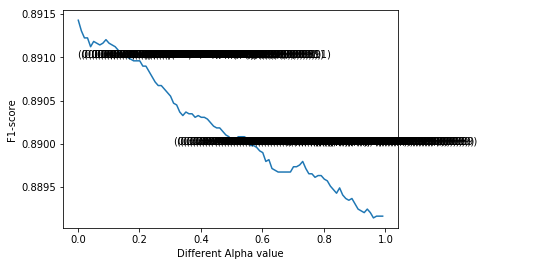

In [15]:
# Plot of f1 w.r.t. alpha value on training data.
alpha = np.arange(0.001,1,0.01)
plt.plot(alpha, TR_scores)
for xy in zip(alpha, np.round(TR_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('Different Alpha value')
plt.ylabel('F1-score')
plt.show()
#print("the F1-score for each alpha value is : ", np.round(TR_scores,6))

### Plot of f1 w.r.t. alpha value on cross validation data.

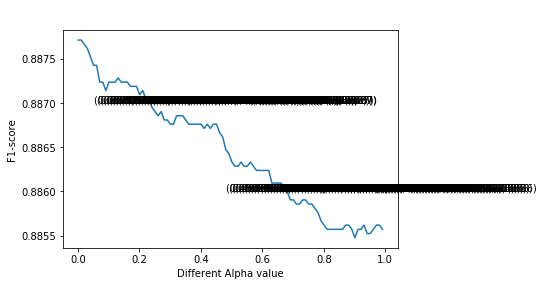

In [16]:
# Plot of f1 w.r.t. alpha value on cross validation data.
alpha = np.arange(0.001,1,0.01)
plt.plot(alpha, cv_scores)
for xy in zip(alpha, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('Different Alpha value')
plt.ylabel('F1-score')
plt.show()
#print("the F1-score for each alpha value is : ", np.round(cv_scores,6))

In [17]:
# Testing on test data for best alpha obtained from simple cross validation
NB = BernoulliNB(alpha = 0.011)
NB.fit(x_trBOW,y_tr)
pred = NB.predict(x_tsBOW)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for aplha = 0.011 is %f%%' % (acc))
f1 = f1_score(y_test, pred, average='micro')
print('\n****Test f1 score for aplha = 0.011 is %f' % (f1))


****Test accuracy for aplha = 0.011 is 88.813333%

****Test f1 score for aplha = 0.011 is 0.888133


### Observation: From simple cross validation we found the best alpha value to be  0.011 and accuracy decreases as we increase alpha. The test accuracy for alpha = 0.011 is 88.813333%, stating the model did not overfit. But as the data is imbalanced we are going for other measures in classification. The f1 score for aplha = 0.011 is 0.888133 in test data. The more close f1-score is to 1 the better it is.

## Performance metrics of classification

In [18]:
# Precision, Recall and F1-score for Naive bayes
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, pred, average='micro')

(0.8881333333333333, 0.8881333333333333, 0.8881333333333333, None)

In [19]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[ 2909,  1532],
       [ 1824, 23735]])

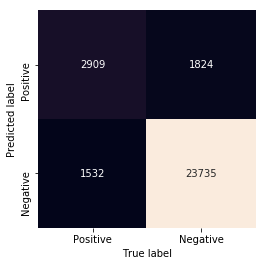

In [20]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

### Observations: Correctly classified points in the test data are 26644 ( = 2909 + 23735) from confusion matrix and misclassified points are 3356 ( = 1824 + 1532)

In [21]:
y_test = np.array(y_test)
ytest = []
for i in range(len(y_test)):
    if y_test[i] == 'positive':
        ytest.append(1)
    else:
        ytest.append(0)

ypred = []
for i in range(len(pred)):
    if pred[i] == 'positive':
        ypred.append(1)
    else:
        ypred.append(0)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(ytest, ypred))

0.7918341779631357


### Observations: The AUC is 0.7918 which is saying the area under ROC curve. The AUC is better than average line classifier.

### Feature Importance according to class represented in wordcloud

In [90]:
# Feature Importance according to class
negative_class = NB.feature_log_prob_[0, :].argsort()
positive_class = NB.feature_log_prob_[1, :].argsort()
neg = np.take(count_vect.get_feature_names(), negative_class[:100])
neg = list(neg)
pos = np.take(count_vect.get_feature_names(), positive_class[:100])
pos = list(pos)

### Positive class Important Words

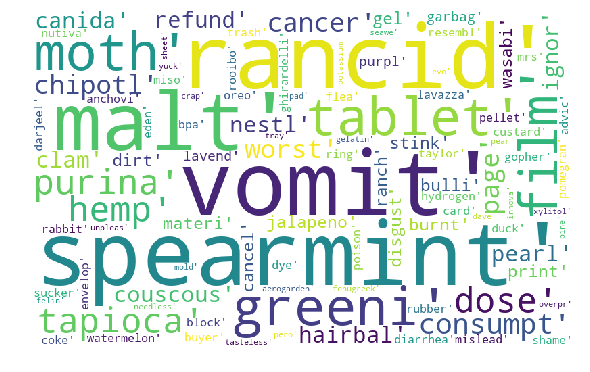

In [91]:
# Positive class Importance Words
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(str(pos))
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None, edgecolor='blue') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### Negative class Important Words

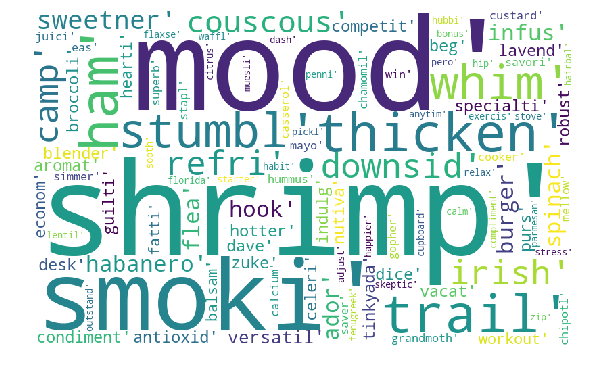

In [92]:
# Positive class Importance Words
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(str(neg))
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None, edgecolor='blue') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### Observations: The above mentioned are the important 100 features/words for both positive and negative class.

## Simple Cross Validation  for multinomialNB. The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [99]:
from sklearn.metrics import f1_score
cv_scores = []
TR_scores = []
for i in np.arange(0.001,1,0.01): # cross checked for alpha value > 1 and alpha value < 1, not giving good results.
    NB = MultinomialNB(alpha = i)
    # fitting the model on crossvalidation train
    NB.fit(x_trBOW, y_tr)

    # predict the response on the crossvalidation train
    pred = NB.predict(x_CVBOW)

    # evaluate CV f1_score
    train_f1 = f1_score(y_tr, train_pred, average='micro')
    f1 = f1_score(y_CV, pred, average='micro')
    #print('\nCV f1 score for aplha = %f is %f' % (i, f1))
    cv_scores.append(f1)
    TR_scores.append(train_f1)

### Observations: 0.888 is the highest F1-score with alpha value = 0.326. Beyond this alpha value, the F1-score remains same till 0.001. That's why there is no point in training our model beyond alpha value = 0.326.

### Observations: The simple cross validation accuracy is decreasing as alpha value increases. For alpha = 0.326, training accuracy is 88.8667%. cross checked for alpha value > 1 and alpha value < 1, not giving good results.

### Plot of f1 w.r.t. alpha value on training data.

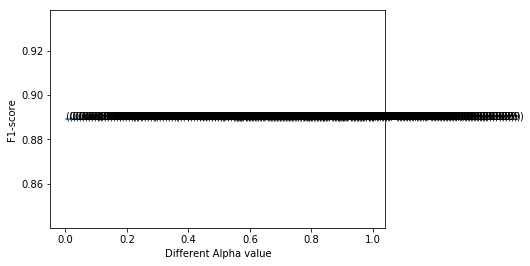

In [100]:
# Plot of f1 w.r.t. alpha value on training data.
alpha = np.arange(0.001,1,0.01)
plt.plot(alpha, TR_scores)
for xy in zip(alpha, np.round(TR_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('Different Alpha value')
plt.ylabel('F1-score')
plt.show()
#print("the F1-score for each alpha value is : ", np.round(TR_scores,6))

### Plot of f1 w.r.t. alpha value on cross validation data.

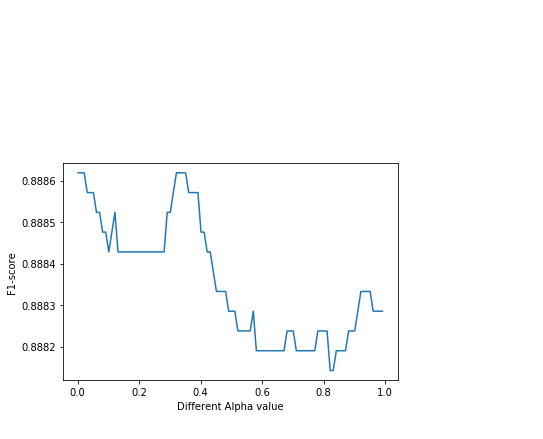

In [98]:
alpha = np.arange(0.001,1,0.01)
plt.plot(alpha, cv_scores)
for xy in zip(alpha, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('Different Alpha value')
plt.ylabel('F1-score')
plt.show()
#print("the F1-score for each alpha value is : ", np.round(cv_scores,6))

In [ ]:
# Testing on test data for best alpha obtained from simple cross validation
NB = MultinomialNB(alpha = 0.326100)
NB.fit(x_trBOW,y_tr)
pred = NB.predict(x_tsBOW)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for aplha = 0.326100 is %f%%' % (acc))
f1 = f1_score(y_test, pred, average='micro')
print('\n****Test f1 score for aplha = 0.326100 is %f' % (f1))

# Observation: From simple cross validation we found the best alpha value to be 0.326100 and accuracy decreases as we increase alpha. The test accuracy for alpha = 0.326100 is 88.836667%, stating the model did not overfit. But as the data is imbalanced we are going for other measures in classification. The f1 score for aplha = 0.326100 is 0.888367 in test data. The more close f1-score is to 1 the better it is.

# Performance metrics of classification

In [ ]:
# Precision, Recall and F1-score for Naive bayes
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, pred, average='weighted')

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

# Observations: Correctly classified points in the test data are 26654 ( = 3048 + 23603) from confusion matrix and misclassified points are 3349 ( = 1393 + 1956)

In [ ]:
y_test = np.array(y_test)
ytest = []
for i in range(len(y_test)):
    if y_test[i] == 'positive':
        ytest.append(1)
    else:
        ytest.append(0)

ypred = []
for i in range(len(pred)):
    if pred[i] == 'positive':
        ypred.append(1)
    else:
        ypred.append(0)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(ytest, ypred))

# Observations: The AUC is 0.8049 which is saying the area under ROC curve. The AUC is better than average line classifier. AUC has increased from BernoulliNB to MultinomialNB.

In [ ]:
# Feature Importance according to class
negative_class = NB.feature_log_prob_[0, :].argsort()
positive_class = NB.feature_log_prob_[1, :].argsort()
print('Negative class')
print(np.take(count_vect.get_feature_names(), negative_class[:100]))
print('\n')
print('positive class')
print(np.take(count_vect.get_feature_names(), positive_class[:100]))

# Observations: The above mentioned are the important 100 features/words for both positive and negative class.

# TF-IDF implementation of Bernoulli Naive Bayes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
X = sample100K_data.iloc[:,:]
y = target

# split the data set into train and test
X_1, X_test, y_1, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0,stratify = y)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.3, random_state=1, stratify = y_1)

In [ ]:
# Making a tf_idf vector. Taking max_features = 2000 and min_df=50 as obtained from literature.
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features = 2000, min_df=50)
x_train_TFIDF = tf_idf_vect.fit_transform(X_tr['CleanedText'].values)

In [ ]:
# Reading the previously created BoW100k feature matirx.
x_trTFIDF = joblib.load('x_train_TFIDF.joblib')
x_CVTFIDF = joblib.load('x_CV_TFIDF.joblib')
x_tsTFIDF = joblib.load('x_test_TFIDF.joblib')
# x_trTFIDF x_CVTFIDF x_tsTFIDF

# Reading the previously created dependent matrix
y_tr = joblib.load('y_tr.joblib')
y_CV = joblib.load('y_cv.joblib')
y_test = joblib.load('y_test.joblib')
# y_tr y_CV y_test

# Simple Cross Validation

In [ ]:
from sklearn.metrics import f1_score
cv_scores = []
for i in np.arange(0.0001,1,0.001): # cross checked for alpha value > 1, not giving good results.
    NB = BernoulliNB(alpha = i)
    # fitting the model on crossvalidation train
    NB.fit(x_trTFIDF, y_tr)

    # predict the response on the crossvalidation train
    pred = NB.predict(x_CVTFIDF)

    # evaluate CV f1_score
     
    f1 = f1_score(y_CV, pred, average='micro')
    print('\nCV f1 score for aplha = %f is %f' % (i, f1))
    cv_scores.append(f1) 

# Observations: 0.889905 is the highest F1-score with alpha value = 0.022100. Beyond this alpha value, the F1-score remains same till 0.0001. That's why there is no point in training our model beyond alpha value = 0.022100.

# Observations: The simple cross validation accuracy is decreasing as alpha value increases. For alpha = 0.022100 training accuracy is 88.9905%. cross checked for alpha value > 1 and alpha value < 1, not giving good results.

In [ ]:
alpha = np.arange(0.0001,1,0.001)

plt.plot(alpha, cv_scores)

for xy in zip(alpha, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Different Alpha value')
plt.ylabel('F1-score')
plt.show()

print("the F1-score for each alpha value is : ", np.round(cv_scores,6))

In [ ]:
# Testing on test data for best alpha obtained from simple cross validation
NB = BernoulliNB(alpha = 0.022100)
NB.fit(x_trTFIDF,y_tr)
pred = NB.predict(x_tsTFIDF)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for aplha = 0.022100 is %f%%' % (acc))
f1 = f1_score(y_test, pred, average='micro')
print('\n****Test f1 score for aplha = 0.022100 is %f' % (f1))

# Observation: From simple cross validation we found the best alpha value to be 0.022100 and accuracy decreases as we increase alpha. The test accuracy for alpha = 0.022100 is 88.886667%, stating the model did not overfit. But as the data is imbalanced we are going for other measures in classification. The f1 score for aplha = 0.022100 is 0.888867 in test data. The more close f1-score is to 1 the better it is.

# Performance metrics of classification

In [ ]:
# Precision, Recall and F1-score for Naive bayes
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, pred, average='weighted')

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

# Observations: Correctly classified points in the test data are 26666 ( = 3073 + 23593) from confusion matrix and misclassified points are 3334 ( = 1966 + 1368)

In [ ]:
y_test = np.array(y_test)
ytest = []
for i in range(len(y_test)):
    if y_test[i] == 'positive':
        ytest.append(1)
    else:
        ytest.append(0)

ypred = []
for i in range(len(pred)):
    if pred[i] == 'positive':
        ypred.append(1)
    else:
        ypred.append(0)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(ytest, ypred))

# Observations: The AUC is 0.8075 which is saying the area under ROC curve. The AUC is better than average line classifier. The AUC has increased from the BOW to TF-IDF featurization

In [ ]:
# Feature Importance according to class
negative_class = NB.feature_log_prob_[0, :].argsort()
positive_class = NB.feature_log_prob_[1, :].argsort()
print('Negative class')
print(np.take(count_vect.get_feature_names(), negative_class[:100]))
print('\n')
print('positive class')
print(np.take(count_vect.get_feature_names(), positive_class[:100]))

# Observations: The above mentioned are the important 100 features/words for both positive and negative class.

# Simple Cross Validation for multinomialNB. The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [ ]:
from sklearn.metrics import f1_score
cv_scores = []
for i in np.arange(0.0001,1,0.001): # cross checked for alpha value > 1 and alpha value < 1, not giving good results.
    NB = MultinomialNB(alpha = i)
    # fitting the model on crossvalidation train
    NB.fit(x_trTFIDF, y_tr)

    # predict the response on the crossvalidation train
    pred = NB.predict(x_CVTFIDF)

    # evaluate CV f1_score
     
    f1 = f1_score(y_CV, pred, average='micro')
    print('\nCV f1 score for aplha = %f is %f' % (i, f1))
    cv_scores.append(f1) 

# Observations: 0.881571 is the highest F1-score with alpha value = 0.034100. Beyond this alpha value, the F1-score remains same till 0.0001. That's why there is no point in training our model beyond alpha value = 0.034100.

# Observations: The simple cross validation accuracy is decreasing as alpha value increases. For alpha = 0.034100 training accuracy is 88.157143%. cross checked for alpha value > 1 and alpha value < 1, not giving good results.

In [ ]:
alpha = np.arange(0.0001,1,0.001)

plt.plot(alpha, cv_scores)

for xy in zip(alpha, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Different Alpha value')
plt.ylabel('F1-score')
plt.show()

print("the F1-score for each alpha value is : ", np.round(cv_scores,6))

In [ ]:
# Testing on test data for best alpha obtained from simple cross validation
NB = MultinomialNB(alpha = 0.034100)
NB.fit(x_trTFIDF,y_tr)
pred = NB.predict(x_tsTFIDF)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for aplha = 0.034100 is %f%%' % (acc))
f1 = f1_score(y_test, pred, average='micro')
print('\n****Test f1 score for aplha = 0.034100 is %f' % (f1))

# Observation: From simple cross validation we found the best alpha value to be 0.034100 and accuracy decreases as we increase alpha. The test accuracy for alpha = 0.034100 is 88.330000%, stating the model did not overfit. But as the data is imbalanced we are going for other measures in classification.  The f1 score for aplha = 0.034100 is 0.883300 in test data. The more close f1-score is to 1 the better it is.

# Performance metrics of classification

In [ ]:
# Precision, Recall and F1-score for Naive bayes
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, pred, average='weighted')

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

# Observations: Correctly classified points in the test data are 26499 ( = 1055 + 25444) from confusion matrix and misclassified points are 3501 ( = 115 + 3386)

In [ ]:
y_test = np.array(y_test)
ytest = []
for i in range(len(y_test)):
    if y_test[i] == 'positive':
        ytest.append(1)
    else:
        ytest.append(0)

ypred = []
for i in range(len(pred)):
    if pred[i] == 'positive':
        ypred.append(1)
    else:
        ypred.append(0)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(ytest, ypred))

# Observations: The AUC is 0.6165 which is saying the area under ROC curve. The AUC is better than average line classifier. AUC has decreased from BernoulliNB to MultinomialNB in TF-IDF featurization.

In [ ]:
# Feature Importance according to class
negative_class = NB.feature_log_prob_[0, :].argsort()
positive_class = NB.feature_log_prob_[1, :].argsort()
print('Negative class')
print(np.take(count_vect.get_feature_names(), negative_class[:100]))
print('\n')
print('positive class')
print(np.take(count_vect.get_feature_names(), positive_class[:100]))

In [ ]:
from prettytable import PrettyTable  
x = PrettyTable()

x.field_names = ["Algorithm", "Featurization", "ROC_AUC", "Alpha","CV_accuracy", "Test_accuracy", "Precision", "Recall", "F1-Score"]

x.add_row(["BernoulliNB", "BOW", 0.791,0.015, 88.77,88.82,0.891,0.888,0.887])
x.add_row(["MultinomialNB", "BOW",0.804,0.326,88.86,88.85,0.894,0.888,0.888])
x.add_row(["BernoulliNB","TF-IDF",0.807,0.022,88.98,88.89,0.895,0.888,0.889])
x.add_row(["MultinomialNB", "TF-IDF", 0.616,0.034,88.15,88.33,0.885,0.883,0.881])

print(x)

# Observations and conclusions: In BOW representation, the ROC_AUC increases from BernoulliNB to MultinomialNB by 0.013 while in TF-IDF representation it decreases from BernoulliNB to MultinomialNB by 0.191. The best alpha value for BernoulliNB in BOW is 0.015, for MultinomialNB in BOW is  0.326, for BernoulliNB in TF-IDF is 0.022 and for MultinomialNB in TF-IDF is  0.034. The cross validation accuracy more or less remains the same in both featurization methods and same holds for test accuracy, precision, recall. The F1-score for all methods slightly changes as the alpha value changes but no drastic increases is obsereved.